In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.stats import hypergeom
import obonet as obo
from tqdm import tqdm

In [3]:
output_dir='/cellar/users/snwright/Data/RareCommon/outputs'
figdir='/cellar/users/snwright/Data/Transfer/RVC/figures/ColocalizedGenes/'

In [4]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.25

### Global results


In [8]:
df = pd.read_csv(os.path.join(output_dir, 'pilot_netcoloc_within_v0.1.txt'), sep='\t', header=None)
df.columns=['TraitR', 'TraitC', 'Network','Mean_NPS', 'Null_mean_NPS', 'P_mean_NPS', 'Size', 'Null_Size', 'P_size' ]
df.head()

,TraitR,TraitC,Network,Mean_NPS,Null_mean_NPS,P_mean_NPS,Size,Null_Size,P_size
0,EFO_0000095,EFO_0000095,pcnet2_0,0.185715,0.003663,3.087000e-64,455,302.886,2.056000e-23
1,EFO_0000182,EFO_0000182,pcnet2_0,0.118129,0.011609,4.129000e-36,347,287.853,4.889000e-05
2,EFO_0000198,EFO_0000198,pcnet2_0,-0.053563,-0.003700,1.000000e+00,175,208.629,9.954000e-01
3,EFO_0000217,EFO_0000217,pcnet2_0,-0.003247,0.002253,7.643000e-01,204,192.122,1.684000e-01
4,EFO_0000266,EFO_0000266,pcnet2_0,0.161343,0.000873,2.705000e-95,336,204.794,5.949000e-26


In [9]:
all_traits = list(df.TraitR.unique())

### Load Z scores

In [10]:
def load_z_scores(trait, outdir=os.path.join(output_dir, 'netcoloc')):
    try:
        rare_z = pd.read_csv(os.path.join(outdir, trait+'_z_RV.tsv'), index_col=0, sep='\t', header=None, names=[trait]).sort_index()
        common_z = pd.read_csv(os.path.join(outdir, trait+'_z_CV.tsv'), index_col=0, sep='\t', header=None, names=[trait]).sort_index()
    except FileNotFoundError:
        print('Trait', trait, 'not found.')
    return rare_z, common_z

def load_all_z_scores(all_traits, outdir=os.path.join(output_dir, 'netcoloc')):
    rare = []
    common = []
    for t in tqdm(all_traits):
        r, c = load_z_scores(t, outdir)
        rare.append(r)
        common.append(c)
    rare_df = pd.concat(rare, axis=1)
    common_df = pd.concat(common, axis=1)
    return rare_df, common_df

In [11]:
rare_df, common_df = load_all_z_scores(all_traits)

100%|██████████| 302/302 [00:35<00:00,  8.49it/s]


In [22]:
coloc_df = rare_df * common_df

### Load gene sets

In [33]:
def load_genes(trait, indir=os.path.join(output_dir, '../inputs')):
    rv = pd.read_csv(os.path.join(indir, trait+'_RV.txt'), sep='\t')
    cv = pd.read_csv(os.path.join(indir, trait+'_CV.txt'), sep='\t')
    return rv['Entrez'].unique(), cv['Entrez'].unique()

In [50]:
network_genes = list(rare_df.index.values)

In [52]:
rare_genes = {}
common_genes = {}
for trait in all_traits:
    rv, cv = load_genes(trait)
    rare_genes[trait] = [g for g in rv if g in network_genes]
    common_genes[trait] = [g for g in cv if g in network_genes]


In [56]:
overlap_genes = {t:set(rare_genes[t]).intersection(common_genes[t]) for t in all_traits}
rare_only = {t:set(rare_genes[t]).difference(common_genes[t]) for t in all_traits}
common_only = {t:set(common_genes[t]).difference(rare_genes[t]) for t in all_traits}

In [57]:
gene_splits = pd.DataFrame({'Overlap':[len(overlap_genes[x]) for x in all_traits], 
                           'RareOnly':[len(rare_only[x]) for x in all_traits],
                           'CommonOnly':[len(common_only[x]) for x in all_traits]}, index=all_traits)

In [58]:
gene_splits.sort_values('Overlap', ascending=False)

,Overlap,RareOnly,CommonOnly
EFO_0004541,124,234,277
EFO_0007805,109,288,302
EFO_0004531,90,154,274
EFO_0004617,71,204,117
EFO_0004584,64,103,407
...,...,...,...
EFO_0004343,0,4,465
EFO_0004465,0,14,153
EFO_0004593,0,10,10
EFO_0004607,0,27,16


In [59]:
rare_df.head()

,EFO_0000095,EFO_0000182,EFO_0000198,EFO_0000217,EFO_0000266,EFO_0000274,EFO_0000275,EFO_0000278,EFO_0000280,EFO_0000284,...,MONDO_0005277,MONDO_0005301,MONDO_0005475,MONDO_0007079,MONDO_0007254,MONDO_0007915,MONDO_0008315,MONDO_0008903,MONDO_0018309,MONDO_0024647
1,2.201470,-0.064286,-0.745352,-0.381560,-0.437369,3.457941,-0.685234,0.070810,0.227321,-0.358006,...,-0.007420,-0.775996,-0.596522,-0.184527,1.015889,-0.235721,-0.695759,-0.606378,1.069330,-0.854117
2,-0.403311,-0.188799,-1.436143,0.469616,0.687906,1.501479,-0.875793,0.565999,1.393555,-0.487109,...,-0.066207,0.320128,0.324544,-0.369044,1.015490,-0.642993,-0.488060,-0.984985,0.804065,-0.789463
9,0.189474,1.827625,-0.886715,0.782902,-0.677435,-0.129292,-1.437661,-1.040589,-0.354858,-0.699863,...,-0.718232,-1.235542,-0.559139,0.484085,-0.742349,3.947169,-0.317240,-0.082412,2.208227,0.014465
10,-0.594422,0.554462,-0.909711,0.683009,-0.638126,0.501231,-1.411912,-0.987330,0.333858,-0.277134,...,-0.845026,-1.285812,-0.341894,0.404902,1.390889,2.925854,-0.417403,0.323694,2.873095,-0.363600
12,0.390819,-0.016393,-1.169100,0.449953,-0.358281,1.864729,-0.788121,0.937563,0.078634,-0.114886,...,-0.094281,-0.545187,-0.674530,-0.344144,1.864177,-0.509815,-0.798852,-0.739987,0.975886,-0.712898


## z scores per gene split

In [125]:
def get_single_z_support(trait, genes, data_df, th=3):
    trait_df = data_df[trait]
    gene_df = trait_df.loc[list(genes)]
    return np.sum(gene_df >= th)

def get_coloc_support(trait, genes, rare_df, common_df, th=3):
    trait_rare = rare_df[trait]
    trait_common = common_df[trait]
    trait_df = pd.DataFrame({'rare':trait_rare, 'common':trait_common}).loc[list(genes)]
    trait_df['coloc'] = trait_df.rare * trait_df.common
    return len(trait_df[(trait_df.coloc >= th) & (trait_df.rare > 1) & (trait_df.common > 1)])

def get_all_support(traits, rare_df, common_df):
    
    results = {'Overlap':{}, 'Rare':{}, 'Common':{}}
    for t in tqdm(traits):
        for i, geneset in enumerate([overlap_genes, rare_only, common_only]):
            rare_n = get_single_z_support(t, geneset[t], rare_df)
            common_n = get_single_z_support(t, geneset[t], common_df)
            coloc_n = get_coloc_support(t, geneset[t], rare_df, common_df)
            results[['Overlap', 'Rare', 'Common'][i]][t] = {'Zr':rare_n, 'Zc':common_n, 'Zrc':coloc_n}
    return results

In [126]:
results_dict = get_all_support(all_traits, rare_df, common_df)

100%|██████████| 302/302 [00:01<00:00, 231.90it/s]


In [127]:
results_overlap = pd.DataFrame.from_dict(results_dict['Overlap'], orient='index')
results_rare = pd.DataFrame.from_dict(results_dict['Rare'], orient='index')
results_common = pd.DataFrame.from_dict(results_dict['Common'], orient='index')
results_rare.columns = ['Rare_'+x for x in  results_rare.columns]
results_common.columns = ['Common_'+x for x in  results_common.columns]

In [121]:
# these results show that all overlapping genes are 'significant by all measures' - is this a red flag?
results_overlap.describe()

,Zr,Zc,Zrc
count,302.000000,302.000000,302.000000
mean,4.788079,4.788079,4.788079
std,14.651481,14.651481,14.651481
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,2.000000,2.000000,2.000000
max,124.000000,124.000000,124.000000


In [129]:
gene_split_results = gene_splits.join(results_rare).join(results_common)

In [130]:
gene_split_results

,Overlap,RareOnly,CommonOnly,Rare_Zr,Rare_Zc,Rare_Zrc,Common_Zr,Common_Zc,Common_Zrc
EFO_0000095,0,8,52,8,0,2,1,52,14
EFO_0000182,0,4,11,4,0,1,0,11,2
EFO_0000198,0,18,6,18,0,0,0,6,0
EFO_0000217,0,65,4,65,1,7,0,4,0
EFO_0000266,0,20,10,20,1,6,0,10,3
...,...,...,...,...,...,...,...,...,...
MONDO_0007915,1,5,260,5,0,2,9,260,52
MONDO_0008315,6,45,298,45,0,10,6,298,64
MONDO_0008903,1,18,79,18,0,5,2,79,25
MONDO_0018309,2,3,5,3,0,1,0,5,2


In [131]:
# Average 20% prioritized by network analysis
(gene_split_results.Common_Zrc / gene_split_results.CommonOnly).describe()

count    301.000000
mean       0.217553
std        0.148293
min        0.000000
25%        0.124731
50%        0.201923
75%        0.307692
max        1.000000
dtype: float64

In [132]:
# Average 25% prioritized by network analysis
(gene_split_results.Rare_Zrc / gene_split_results.RareOnly).describe()

count    300.000000
mean       0.251587
std        0.194561
min        0.000000
25%        0.114316
50%        0.222222
75%        0.336538
max        1.000000
dtype: float64

In [138]:
gene_splits['trait'] = gene_splits.index

In [142]:
gene_splits

,Overlap,RareOnly,CommonOnly,trait
EFO_0000095,0,8,52,EFO_0000095
EFO_0000182,0,4,11,EFO_0000182
EFO_0000198,0,18,6,EFO_0000198
EFO_0000217,0,65,4,EFO_0000217
EFO_0000266,0,20,10,EFO_0000266
...,...,...,...,...
MONDO_0007915,1,5,260,MONDO_0007915
MONDO_0008315,6,45,298,MONDO_0008315
MONDO_0008903,1,18,79,MONDO_0008903
MONDO_0018309,2,3,5,MONDO_0018309


In [143]:
gene_splits['overlap+rare'] = gene_splits['Overlap'] + gene_splits['RareOnly']
gene_splits['Total'] = gene_splits['overlap+rare'] + gene_splits['CommonOnly']
gene_splits = gene_splits.sort_values(by=['Overlap', 'overlap+rare', 'Total'], ascending=False)

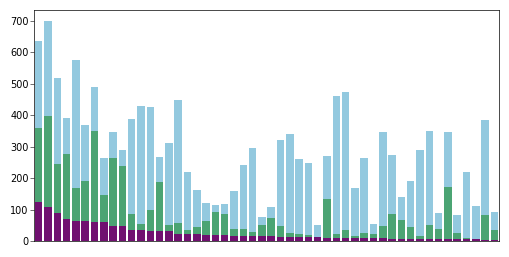

In [207]:
_ = plt.figure(figsize=(6, 3))
sns.barplot(gene_splits[0:50], x='trait', y='Overlap', color='purple', zorder=10, )
sns.barplot(gene_splits[0:50], x='trait', y='overlap+rare', color='mediumseagreen', zorder=5, )
sns.barplot(gene_splits[0:50], x='trait', y='Total', color='skyblue', zorder=1, )
_ = plt.xticks([])
plt.ylabel('')
plt.xlabel('')
plt.savefig(os.path.join(figdir, 'overlap_bar_updated.jpg'), dpi=400, bbox_inches='tight')

In [179]:
gene_split_results['trait'] = gene_split_results.index
gene_split_results['overlap+rare'] = gene_split_results['Overlap'] + gene_split_results['RareOnly']
gene_split_results['Total'] = gene_split_results['overlap+rare'] + gene_split_results['CommonOnly']
gene_split_results['overlap+RareZ'] = gene_split_results['Overlap'] + gene_split_results['Rare_Zrc']
gene_split_results['overlap+RareCommonZ'] = gene_split_results['overlap+RareZ'] + gene_split_results['Common_Zrc']

gene_split_results = gene_split_results.sort_values(by=['Overlap', 'overlap+RareZ', 'overlap+RareCommonZ'], ascending=False)

In [202]:
(gene_split_results.iloc[0:50]['overlap+RareCommonZ']/gene_split_results.iloc[0:50]['Overlap']).describe()

count    50.000000
mean      6.720424
std       4.677923
min       1.750000
25%       3.253571
50%       4.812605
75%       8.812500
max      24.000000
dtype: float64

In [1]:
_ = plt.figure(figsize=(6, 3))
sns.barplot(gene_split_results[0:50], x='trait', y='Overlap', color='purple', zorder=10,)
sns.barplot(gene_split_results[0:50], x='trait', y='overlap+RareZ', color='mediumseagreen', zorder=5)
sns.barplot(gene_split_results[0:50], x='trait', y='overlap+RareCommonZ', color='skyblue', zorder=3)
sns.barplot(gene_split_results[0:50], x='trait', y='Total', color='lightgrey', zorder=1, saturation=1)
_ = plt.xticks([])
plt.ylabel('')
plt.xlabel('')
plt.savefig(os.path.join(figdir, 'overlap_bar_prioritized_updated.jpg'), dpi=400, bbox_inches='tight')

NameError: name 'plt' is not defined

In [151]:
gene_split_results.head()

,Overlap,RareOnly,CommonOnly,Rare_Zr,Rare_Zc,Rare_Zrc,Common_Zr,Common_Zc,Common_Zrc
EFO_0000095,0,8,52,8,0,2,1,52,14
EFO_0000182,0,4,11,4,0,1,0,11,2
EFO_0000198,0,18,6,18,0,0,0,6,0
EFO_0000217,0,65,4,65,1,7,0,4,0
EFO_0000266,0,20,10,20,1,6,0,10,3
